In [1]:
%matplotlib inline
import os
from subprocess import check_call

from datetime import datetime 
import calendar

import pandas as pd
import xarray as xr
import numpy as np

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import cmocean

import ssmi_seaice

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img'

if not os.path.exists('./fig'):
    os.makedirs('./fig')             
    

In [2]:
dss = ssmi_seaice.obs_seaice('south')
dsn = ssmi_seaice.obs_seaice('north')

### define functions for plotting sea ice maps

In [3]:
def plot_south(ax,ifrac):
    ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

    ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')
    #ax.background_img('nasa-bluemarble-topo-2004-01',resolution='large')

    pc = ax.pcolormesh(dss.lon,dss.lat,ifrac*100.,
                       vmin=0.,vmax=100.,
                       cmap='Blues_r',
                       transform=ccrs.PlateCarree())

    ax.set_rasterization_zorder(2)
    pc.set_rasterized(True)
    pc.set_zorder(1)
    ax.coastlines('10m',linewidth=0.5,zorder=10)
    return ax,pc

def plot_north(ax,ifrac):
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    
    ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')
    #ax.background_img('nasa-bluemarble-topo-2004-07',resolution='large')

    
    pc = ax.pcolormesh(dsn.lon,dsn.lat,ifrac*100.,
                       vmin=0.,vmax=100.,
                       cmap='Blues_r',
                       transform=ccrs.PlateCarree())

    ax.set_rasterization_zorder(2)
    pc.set_rasterized(True)
    pc.set_zorder(1)
    ax.coastlines('10m',linewidth=0.5,zorder=10)
    return ax, pc

### compute and plot seasonal climatologies

Summer = JAS (Arctic) and JFM (Antarctic)<br>
Winter = JFM (Arctic) and JAS (Antarctic)

In [4]:
dss_m = dss.sel(time=slice('1981','2010')).groupby('time.month').mean('time')
dsn_m = dsn.sel(time=slice('1981','2010')).groupby('time.month').mean('time')

dss_jfm = dss_m.isel(month=slice(0,3)).mean('month').compute()
dsn_jfm = dsn_m.isel(month=slice(0,3)).mean('month').compute()

dss_jas = dss_m.isel(month=slice(6,9)).mean('month').compute()
dsn_jas = dsn_m.isel(month=slice(6,9)).mean('month').compute()

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


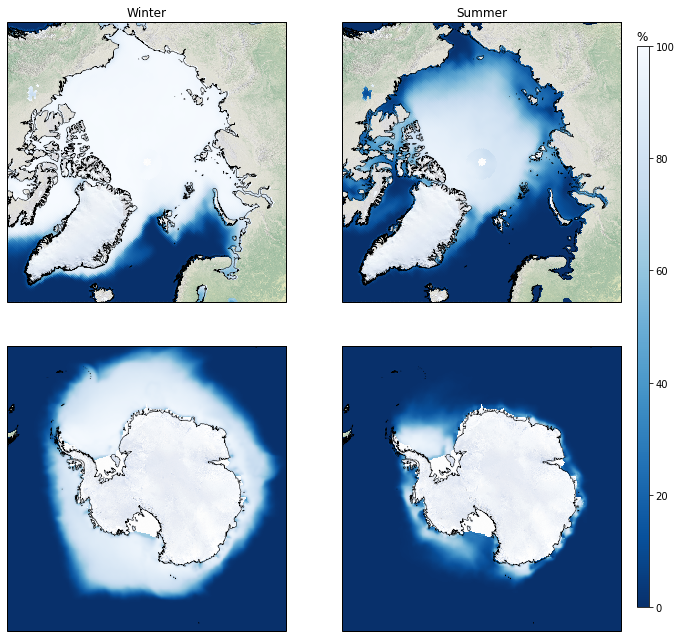

In [5]:
plot_name = f'fig/ssmi-ifrac-seasonal-climatology.png'

fig = plt.figure(figsize=(11,12))
axs = []

ax = fig.add_subplot(2,2,1, projection=ccrs.NorthPolarStereo())
ax,pc = plot_north(ax,dsn_jfm.ifrac)
ax.set_title('Winter')
axs.append(ax)

ax = fig.add_subplot(2,2,2, projection=ccrs.NorthPolarStereo())
ax,pc = plot_north(ax,dsn_jas.ifrac)
ax.set_title('Summer')
axs.append(ax)

ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax,pc = plot_south(ax,dss_jas.ifrac)
axs.append(ax)

ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax,pc = plot_south(ax,dss_jfm.ifrac)
axs.append(ax)

plt.subplots_adjust(right=0.9,hspace=0.001)
ptop = axs[0].get_position()
pbot = axs[-1].get_position()
height = ptop.y0 + ptop.height - pbot.y0
cbar_height = 0.65
y0 = pbot.y0+height/2-cbar_height/2 

cax = plt.axes((0.92,y0,0.015,cbar_height))
cax.set_title('%',loc='left')
plt.colorbar(pc,cax=cax)    

fig.savefig(plot_name,dpi=300,bbox_inches='tight')


# compute monthly anomalies in sea ice extent

Extent is defined as area with ice cover above 15%

Inspired by [Stroeve and Notz, 2018](http://iopscience.iop.org/article/10.1088/1748-9326/aade56/pdf).

In [6]:
extent_thres = 0.15
extent_attrs = {'long_name':'Sea-ice extent','units':'10$^{6}$ km$^{2}$'}

pole_hole_area = dsn.area.where(dsn.pole_mask==1).sum(['nx','ny']) * 1e-6 

extent = xr.Dataset()
extent['NH'] = dsn.area.where(dsn.ifrac>=extent_thres).sum(['nx','ny']) * 1e-6 + pole_hole_area
extent['SH'] = dss.area.where(dss.ifrac>=extent_thres).sum(['nx','ny']) * 1e-6

extent.NH.attrs = extent_attrs
extent.SH.attrs = extent_attrs
extent

<xarray.Dataset>
Dimensions:  (time: 12661)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-26 1978-10-28 ... 2017-12-31
Data variables:
    NH       (time) float64 dask.array<shape=(12661,), chunksize=(792,)>
    SH       (time) float64 dask.array<shape=(12661,), chunksize=(792,)>

Compute monthly means

In [7]:
extent_m = extent.resample(time='1M').mean().compute()
extent_m

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


<xarray.Dataset>
Dimensions:  (time: 471)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-31 1978-11-30 ... 2017-12-31
Data variables:
    NH       (time) float64 10.62 11.83 13.9 15.7 ... 5.008 6.971 9.755 12.0
    SH       (time) float64 17.7 15.9 10.4 5.402 ... 17.91 17.78 15.11 9.482

Compute monthly climatology for reference period (1981-2010) and normalized anomalies.

In [8]:
extent_clim = extent_m.sel(time=slice('1981','2010')).groupby('time.month').mean('time').compute()
extent_std = extent_m.sel(time=slice('1981','2010')).groupby('time.month').std('time').compute()
extent_clim

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NH       (month) float64 14.71 15.61 15.74 14.95 ... 6.601 8.52 10.93 13.06
    SH       (month) float64 4.961 3.067 4.03 6.848 ... 18.49 18.1 15.9 10.51

In [9]:
extent_tbl = xr.merge((extent_clim,extent_std.rename({'NH':'NH_std','SH':'SH_std'}))).to_dataframe()
extent_tbl

,NH,SH,NH_std,SH_std
month,,,,
1,14.714765,4.961499,0.476008,0.565774
2,15.612183,3.066872,0.472662,0.337918
3,15.741560,4.029501,0.443068,0.437085
4,14.948232,6.847944,0.435612,0.525612
5,13.546637,10.162878,0.387870,0.507235
6,11.949794,13.350970,0.476558,0.459053
7,9.604950,15.960677,0.704486,0.339126
8,7.333672,17.725088,0.750007,0.318406
9,6.600737,18.486937,0.867033,0.339508


Compute standardized anomalies

In [10]:
extent_anom = (extent_m.groupby('time.month') - extent_clim).groupby('time.month') / extent_std
extent_anom

<xarray.Dataset>
Dimensions:  (time: 471)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-31 1978-11-30 ... 2017-12-31
    month    (time) int64 10 11 12 1 2 3 4 5 6 7 8 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NH       (time) float64 2.568 1.574 1.726 2.069 ... -1.892 -2.057 -2.191
    SH       (time) float64 -1.165 0.0008721 -0.1429 ... -0.9388 -2.307 -1.273

In [11]:
extent_anom = extent_anom.compute()

Reformat standardized anomalies into month x year matrix

In [12]:
mon = extent_anom['time.month'].values
year = extent_anom['time.year'].values
uniyear = np.unique(year)
nyear = len(uniyear)

In [13]:
anom_matrix = xr.Dataset({
    'NH':xr.DataArray(np.empty((12,nyear)),dims=('mon','year')),
    'SH':xr.DataArray(np.empty((12,nyear)),dims=('mon','year')),
    'year': xr.DataArray(uniyear,dims=('year')),
    'mon': xr.DataArray(np.arange(1,13,1),dims=('mon'))})

for l in range(len(extent_anom.time)):
    i = mon[l] - 1
    j = year[l] - year[0]
    anom_matrix.NH.values[i,j] = extent_anom.NH.values[l]
    anom_matrix.SH.values[i,j] = extent_anom.SH.values[l]
    
anom_matrix

<xarray.Dataset>
Dimensions:  (mon: 12, year: 40)
Coordinates:
  * year     (year) int64 1978 1979 1980 1981 1982 ... 2013 2014 2015 2016 2017
  * mon      (mon) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NH       (mon, year) float64 2.361e-310 2.069 0.7965 ... -2.771 -2.191
    SH       (mon, year) float64 2.361e-310 0.7789 -0.7059 ... -2.762 -1.273

Check Arctic calculation against [Stroeve and Notz, 2018](http://iopscience.iop.org/article/10.1088/1748-9326/aade56/pdf).

[-0.29476481 -0.31218286 -0.31155964 -0.25823211 -0.2566365  -0.18979392
 -0.13494988 -0.13367177 -0.19073724 -0.16966535 -0.22823477 -0.22317264]
[-1.60084573e-02 -1.26624826e-02 -2.30683832e-02  4.38829719e-03
  2.13001101e-03 -6.55809538e-03 -4.48556189e-03 -7.12931705e-06
  2.96715928e-03  1.12625853e-02 -2.05529108e-04  1.42192299e-02]


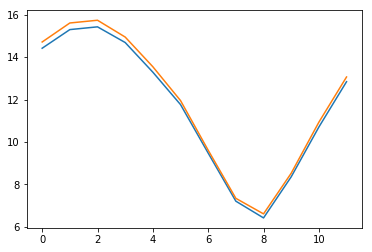

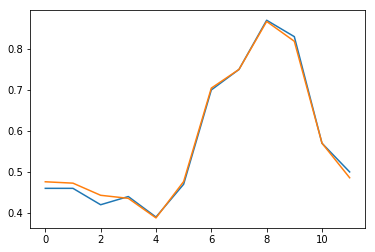

In [14]:
# numbers for mean and standard deviation from table 1
ext_check_mnn = np.array([14.42,15.30,15.43,14.69,13.29,11.76,9.47 ,7.20 ,6.41 ,8.35 ,10.70,12.84])
ext_check_std = np.array([0.46,0.46,0.42,0.44,0.39,0.47,0.70,0.75,0.87,0.83,0.57,0.50])

plt.figure()
plt.plot(ext_check_mnn)
plt.plot(extent_clim.NH)
print(ext_check_mnn - extent_clim.NH.values)

plt.figure()
plt.plot(ext_check_std)
plt.plot(extent_std.NH)
print(ext_check_std - extent_std.NH.values)

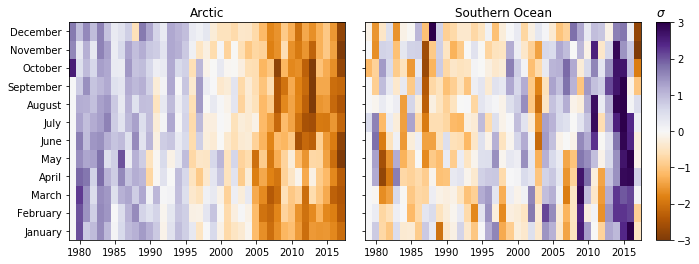

In [15]:
fig = plt.figure(figsize=(10,4))

cmap = 'PuOr' #cmocean.cm.delta

ax = fig.add_subplot(121)
p1 = ax.pcolormesh(uniyear+0.5,np.arange(0.5,13,1),anom_matrix.NH,cmap=cmap,vmin=-3,vmax=3)
ax.set_yticks(np.arange(1,13,1))
ax.set_yticklabels([calendar.month_name[i] for i in range(1,13)])
ax.set_xticks(np.arange(1980,2020,5))
tx = ax.set_title('Arctic')


ax = fig.add_subplot(122)
p2 = ax.pcolormesh(uniyear+0.5,np.arange(0.5,13,1),anom_matrix.SH,cmap=cmap,vmin=-3,vmax=3)
ax.set_yticks(np.arange(1,13,1))
ax.set_yticklabels([])
ax.set_xticks(np.arange(1980,2020,5))
tx = ax.set_title('Southern Ocean')


fig.subplots_adjust(right=0.92,wspace=0.075)

p = ax.get_position()
cax = fig.add_axes([0.94,p.y0,0.02,p.height])
fig.colorbar(p1,cax=cax)
cax.set_title('$\sigma$',loc='left')
plt.savefig(f'fig/ssmi-seaice-anom-matrix.pdf',bbox_inches='tight',dpi=300)